# Notebook pour le tracé des cartes d'indicateurs VHI AGREGEES (Stats par AREAS)

### Initialisation contexte test appli

In [11]:
import os

WRK_DIR = os.path.normpath('D:/MATHIS/0_Projet_Secheresse/1_Scripts/toolbox/eo4dm-oeil/EO4DM')
os.chdir(WRK_DIR)
WRK_DIR= os.path.join('Y:/EO4DM')

TERRITORY = 'New Caledonia (Fr)'
PRODUCT = 'VHI'
LANDMASK = '' # if no mask set ''
PERIOD = 'M'    # D=decade, M=month
DATE = '201910'
AREA = 'POUEMBOUT'
areas_key = 'nom'

TERRITORY_str = TERRITORY.replace(' ', '_').replace('(', '').replace(')', '')
DATA_HISTO = os.path.join(WRK_DIR,'DATA_HISTO',TERRITORY_str)
ANNEX_DIR = os.path.join(WRK_DIR,'ANNEX',TERRITORY_str)
INDIR_STATS = os.path.join(DATA_HISTO,'1_INDICATEURS/GLOBAL/STATS')
INDIR_ANNEX = os.path.join(ANNEX_DIR,'Areas')

In [12]:
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon
import contextily as ctx
from matplotlib_scalebar.scalebar import ScaleBar

### Prépare le dossier de sortie

In [13]:
# --- Generate directories/sub-directories ---
OUTDIR_MAPS = os.path.join(WRK_DIR, f'PLOT_MAP_DROUGHT_{TERRITORY_str}')
os.umask(0) # used to reset the directories permission
if not os.path.exists(OUTDIR_MAPS):
    os.makedirs(OUTDIR_MAPS)
    os.chmod(OUTDIR_MAPS, 0o777)

### Lecture et préparation des données

In [14]:
instats_csv = glob.glob(os.path.join(INDIR_STATS, f'*STATS*{PERIOD}*{LANDMASK}*.csv'))[0]
instats_df = pd.read_csv(instats_csv,sep=';',decimal='.')
try:
    instats_df['DATE'] = pd.to_datetime(instats_df.DATE, format='%Y-%m-%d')
except ValueError:
    instats_df['DATE'] = pd.to_datetime(instats_df.DATE, format='%d/%m/%Y')

# Extract dataframe on selected Date :
date_dt = pd.to_datetime(DATE, format='%Y%m')
instats_date_df = instats_df.loc[instats_df['DATE']==date_dt]

# Extract Contours :
contours_in = glob.glob(os.path.join(INDIR_ANNEX, '*.shp'))[0]
gdf_contours = gpd.read_file(contours_in)
gdf_area = gdf_contours.sort_values(areas_key).reset_index(drop=True)

# Extract dataframe on selected Contours :
areas_list = [str(i) for i in list(gdf_area[areas_key].unique())]
instats_contours_df = instats_date_df[instats_date_df['LOCATION'].isin(areas_list)]
instats_contours_df = instats_contours_df.sort_values('LOCATION').reset_index(drop=True)

# Add Contours geom to dataframe :
instats_gdf = gpd.GeoDataFrame(instats_contours_df, geometry=gdf_area['geometry'])


In [15]:
instats_gdf

,LOCATION,DATE,MEAN,MIN,MAX,STD,QSCORE,geometry
0,BELEP,2019-10-01,0.37,0.00,0.72,0.14,0.24,"MULTIPOLYGON Z (((150476.873 506140.422 1.000,..."
1,BOULOUPARIS,2019-10-01,0.27,0.00,0.82,0.17,0.33,"MULTIPOLYGON Z (((416716.427 245328.251 1.000,..."
2,BOURAIL,2019-10-01,0.39,0.00,0.84,0.13,0.31,MULTIPOLYGON Z (((321269.784 300678.563 -10000...
3,CANALA,2019-10-01,0.42,0.00,0.84,0.13,0.25,MULTIPOLYGON Z (((386717.798 316039.558 -10000...
4,DUMBEA,2019-10-01,0.46,0.05,0.86,0.13,0.22,MULTIPOLYGON Z (((439992.642 225404.891 -10000...
5,FARINO,2019-10-01,0.33,0.11,0.69,0.14,0.23,"POLYGON Z ((371109.153 280137.791 9999.000, 37..."
6,HIENGHENE,2019-10-01,0.53,0.04,0.92,0.14,0.26,MULTIPOLYGON Z (((298469.205 386133.942 -10000...
7,HOUAILOU,2019-10-01,0.54,0.09,0.97,0.13,0.23,MULTIPOLYGON Z (((353095.755 339880.000 -10000...
8,ILE DES PINS,2019-10-01,0.45,0.09,0.87,0.14,0.27,"MULTIPOLYGON Z (((546437.236 174641.729 1.000,..."
9,KAALA GOMEN,2019-10-01,0.36,0.04,0.81,0.13,0.38,MULTIPOLYGON Z (((248580.913 366116.844 -10000...


### Définition des colormaps

In [16]:
colormap_drought = ['black', 'red', 'orange', 'yellow', 'white']
class_drought = [0, 0.1, 0.2, 0.3, 0.4, 1]
color_nodata = '#DCDCDC' # lightgray
# color_nodata = '#add8e6' # lightblue

### Affichage et export de la carte

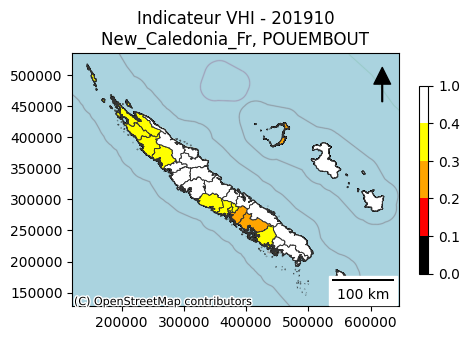

In [17]:
cmap = mcolors.ListedColormap(colormap_drought)
norm = mcolors.BoundaryNorm(class_drought, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(5, 5))

ax.set_facecolor(color_nodata)
gdf_area.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

if TERRITORY=='Fiji' or TERRITORY=='Vanuatu':
    for geometry in gdf_contours['geometry']:
        if geometry.geom_type == 'Polygon':
            ax.add_patch(plt.Polygon(list(geometry.exterior.coords), facecolor=color_nodata, zorder=-1))
        elif geometry.geom_type == 'MultiPolygon':
            for poly in geometry.geoms:
                ax.add_patch(plt.Polygon(list(poly.exterior.coords), facecolor=color_nodata, zorder=-1))

im = instats_gdf.plot(column='MEAN',
                 cmap=cmap,
                 norm=norm,
                 linewidth=.6,
                 edgecolor='0.2',
                 ax=ax,
                 legend=True,
                 legend_kwds = {'shrink':0.4})

ctx.add_basemap(ax, crs=instats_gdf.crs, source=ctx.providers.OpenStreetMap.Mapnik, zorder=-1)

# Add Scale bar
distance_meters = 1
bounds = gdf_area.geometry.bounds
if instats_gdf.crs=='EPSG:4326':
    points_x =[bounds.minx.values[0], bounds.minx.values[0]+1]
    points_y = [bounds.miny.values[0], bounds.miny.values[0]]
    points = gpd.GeoSeries.from_xy(points_x, points_y, crs='EPSG:4326')
    points = points.to_crs(3395)
    distance_meters = points[0].distance(points[1])
ax.add_artist(ScaleBar(distance_meters, location='lower right'))

# Add North arrow
arrow_properties = dict(facecolor='black', edgecolor='black', width=0.5, shrink=0.05)
ax.annotate('', xy=(0.95, 0.95), xytext=(0.95, 0.8),
            arrowprops=arrow_properties, ha='center', va='bottom',
            fontsize=12, color='black', xycoords='axes fraction')

plt.title(f'Indicateur {PRODUCT} - {DATE}\n{TERRITORY_str}, {AREA}')
plt.tight_layout()
plt.show()

# Save figure
fig.savefig(os.path.join(OUTDIR_MAPS, f'maps_aggregAreas_{PRODUCT}_{TERRITORY_str}_{AREA}_{DATE}.png'), dpi=300)
